IMPORTING NECESSARY LIBRARIES

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

READING DATA

In [ ]:
PATH='/content' #CHANGE TO YOUR FOLDER WITH DATA
human_data=pd.read_table(PATH+'/human.txt')
dog_data=pd.read_table(PATH+'/dog.txt')
chimpanzee_data=pd.read_table(PATH+'/chimpanzee.txt')

SHORT EXPLORATORY DATA ANALYSIS

In [ ]:
#printing first 5 rows of human_data
human_data.head()

,sequence,class
0,ATGCCCCAACTAAATACTACCGTATGGCCCACCATAATTACCCCCA...,4
1,ATGAACGAAAATCTGTTCGCTTCATTCATTGCCCCCACAATCCTAG...,4
2,ATGTGTGGCATTTGGGCGCTGTTTGGCAGTGATGATTGCCTTTCTG...,3
3,ATGTGTGGCATTTGGGCGCTGTTTGGCAGTGATGATTGCCTTTCTG...,3
4,ATGCAACAGCATTTTGAATTTGAATACCAGACCAAAGTGGATGGTG...,3


[Text(0.5, 1.0, 'Classes distribution (human)')]

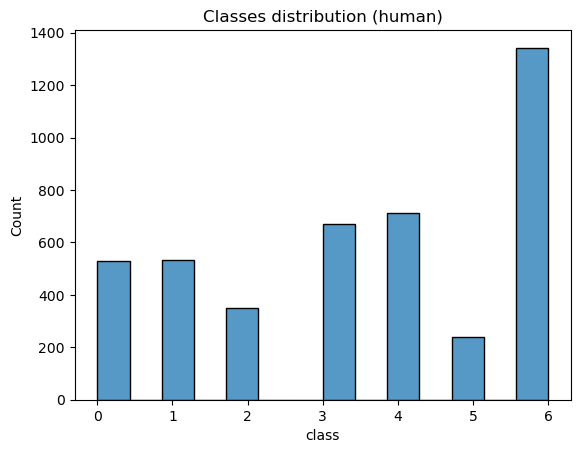

In [ ]:
#checking classes distribution with histogram
sns.histplot(data=human_data, x='class').set(title='Classes distribution (human)')

In [ ]:
#printing first 5 rows of dog_data
dog_data.head()

,sequence,class,kmers
0,ATGCCCCAACTAAATACTACCGTATGGCCCACCATAATTACCCCCA...,4,"[ATGCC, TGCCC, GCCCC, CCCCA, CCCAA, CCAAC, CAA..."
1,ATGAACGAAAATCTGTTCGCTTCATTCATTGCCCCCACAATCCTAG...,4,"[ATGAA, TGAAC, GAACG, AACGA, ACGAA, CGAAA, GAA..."
2,ATGTGTGGCATTTGGGCGCTGTTTGGCAGTGATGATTGCCTTTCTG...,3,"[ATGTG, TGTGT, GTGTG, TGTGG, GTGGC, TGGCA, GGC..."
3,ATGTGTGGCATTTGGGCGCTGTTTGGCAGTGATGATTGCCTTTCTG...,3,"[ATGTG, TGTGT, GTGTG, TGTGG, GTGGC, TGGCA, GGC..."
4,ATGCAACAGCATTTTGAATTTGAATACCAGACCAAAGTGGATGGTG...,3,"[ATGCA, TGCAA, GCAAC, CAACA, AACAG, ACAGC, CAG..."


[Text(0.5, 1.0, 'Classes distribution (dog)')]

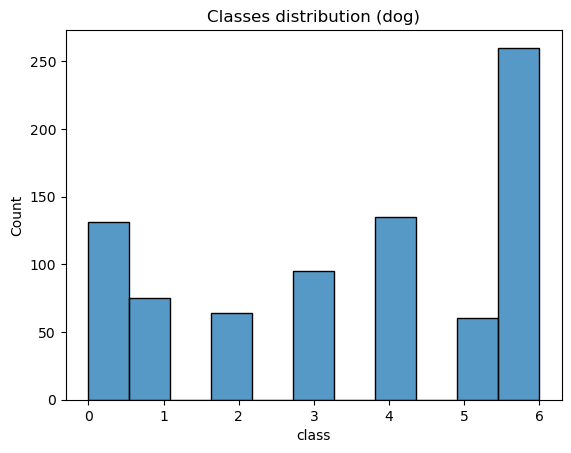

In [ ]:
#checking classes distribution with histogram
sns.histplot(data=dog_data, x='class').set(title='Classes distribution (dog)')

In [ ]:
#printing first five rows of chimpanzee_data
chimpanzee_data.head()

,sequence,class
0,ATGCCCCAACTAAATACCGCCGTATGACCCACCATAATTACCCCCA...,4
1,ATGAACGAAAATCTATTCGCTTCATTCGCTGCCCCCACAATCCTAG...,4
2,ATGGCCTCGCGCTGGTGGCGGTGGCGACGCGGCTGCTCCTGGAGGC...,4
3,ATGGCCTCGCGCTGGTGGCGGTGGCGACGCGGCTGCTCCTGGAGGC...,4
4,ATGGGCAGCGCCAGCCCGGGTCTGAGCAGCGTGTCCCCCAGCCACC...,6


[Text(0.5, 1.0, 'Classes distribution (chimpanzee)')]

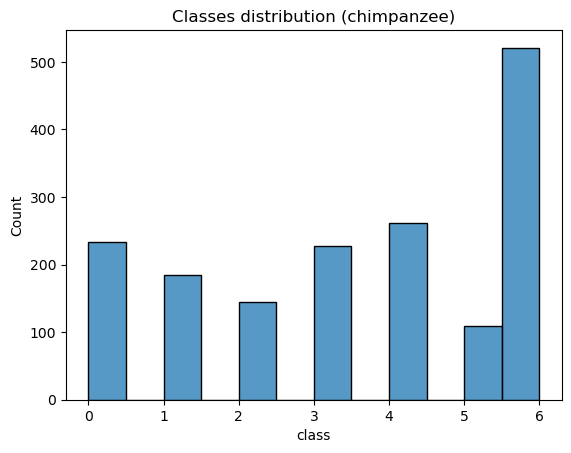

In [ ]:
#checking classes distribution with histogram
sns.histplot(data=chimpanzee_data, x='class').set(title='Classes distribution (chimpanzee)')

CLASSES HAVE IMBALANCED DISTRIBUTION WITHIN ALL THREE FILES (WITH CLASS 6 DOMINATING), HOWEVER THE DISTRIBUTIONS WITHIN ALL FILES ARE SIMILAR

In [ ]:
#some of the sequences contain N characters
human_data[human_data['sequence'].str.contains('N')]

,sequence,class
34,NGGCAAACAAGAGAGAAAGCAAAATTTTCAGATGGAGAAAAGTGCC...,6
44,NTGCAGGTGATTTTCAAAGCCAAGTCAAAATATTCTCCAGAATTAC...,0
46,NNGTTAAACCTCAGCATCGGCGGCCCGGACTTCATGGATCATCCGT...,6
54,NGCCTCGCAGGCAGCACCAGCCTCATGCACAACCACGCGGCCCTCC...,6
59,NCCATGTCACTGGGCGGGCGGCACGCAGGCCTGGTTGGAGGCAGCC...,6
...,...,...
4266,NCCATCACCTTCTACCAGACACTGTGGGCCCGGCCCCGGAGGGCTC...,0
4270,NNTGCAGCCGCCTACCTGCTCCAGGGAAGCTTCTATGGCCACTCCA...,4
4311,NCTATGGATTCTTCTGCAGTTTATGTGTTAAGTAGTATGGCTCGCC...,6
4335,NACGCCTGGTGA,1


SOME OF THE SEQUENCES CONTAIN N LETTER

In [ ]:
#checking if number of sequences with N character is the same as the number of sequences starting with N character -> true
len(human_data[human_data['sequence'].str.contains('N')])==len(human_data[human_data['sequence'].str.startswith('N')])

True

NUMBER OF SEQUENCES WITH THE N LETTER IS THE SAME AS THE NUMBER OF SEQUENCES STARTING WITH N LETTER -> ASSUMING N APPEARS ONLY AT THE BEGINNING AND THEREFORE THE BEGINNING OF THOSE SENTENCES CAN BE CUT REPLACING N CHARACTERS WITH EMPTY STRING

In [ ]:
#replacing all N characters with empty string ( = removing N letter)
#this should not be a problem since i am sliding kmers anyway
human_data.loc[human_data['sequence'].str.startswith('N'), 'sequence'] = human_data.loc[human_data['sequence'].str.startswith('N'), 'sequence'].str.replace('N', '')

In [ ]:
#making sure there are no sequences with N letter left
human_data[human_data['sequence'].str.contains('N')]

,sequence,class


FUNCTION TO GENERATE KMERS

In [ ]:
#simple function to slide through sequence and create kmers
def create_kmers(sequence, k=4):
    return [sequence[i:i+k] for i in range(0,len(sequence)-k+1,1)]

In [ ]:
#taking first sequence to validate how function works
sequence=human_data['sequence'].iloc[0]
sequence

'ATGCCCCAACTAAATACTACCGTATGGCCCACCATAATTACCCCCATACTCCTTACACTATTCCTCATCACCCAACTAAAAATATTAAACACAAACTACCACCTACCTCCCTCACCAAAGCCCATAAAAATAAAAAATTATAACAAACCCTGAGAACCAAAATGAACGAAAATCTGTTCGCTTCATTCATTGCCCCCACAATCCTAG'

In [ ]:
#creating example kmers
create_kmers(sequence, k=4)

['ATGC',
 'TGCC',
 'GCCC',
 'CCCC',
 'CCCA',
 'CCAA',
 'CAAC',
 'AACT',
 'ACTA',
 'CTAA',
 'TAAA',
 'AAAT',
 'AATA',
 'ATAC',
 'TACT',
 'ACTA',
 'CTAC',
 'TACC',
 'ACCG',
 'CCGT',
 'CGTA',
 'GTAT',
 'TATG',
 'ATGG',
 'TGGC',
 'GGCC',
 'GCCC',
 'CCCA',
 'CCAC',
 'CACC',
 'ACCA',
 'CCAT',
 'CATA',
 'ATAA',
 'TAAT',
 'AATT',
 'ATTA',
 'TTAC',
 'TACC',
 'ACCC',
 'CCCC',
 'CCCC',
 'CCCA',
 'CCAT',
 'CATA',
 'ATAC',
 'TACT',
 'ACTC',
 'CTCC',
 'TCCT',
 'CCTT',
 'CTTA',
 'TTAC',
 'TACA',
 'ACAC',
 'CACT',
 'ACTA',
 'CTAT',
 'TATT',
 'ATTC',
 'TTCC',
 'TCCT',
 'CCTC',
 'CTCA',
 'TCAT',
 'CATC',
 'ATCA',
 'TCAC',
 'CACC',
 'ACCC',
 'CCCA',
 'CCAA',
 'CAAC',
 'AACT',
 'ACTA',
 'CTAA',
 'TAAA',
 'AAAA',
 'AAAA',
 'AAAT',
 'AATA',
 'ATAT',
 'TATT',
 'ATTA',
 'TTAA',
 'TAAA',
 'AAAC',
 'AACA',
 'ACAC',
 'CACA',
 'ACAA',
 'CAAA',
 'AAAC',
 'AACT',
 'ACTA',
 'CTAC',
 'TACC',
 'ACCA',
 'CCAC',
 'CACC',
 'ACCT',
 'CCTA',
 'CTAC',
 'TACC',
 'ACCT',
 'CCTC',
 'CTCC',
 'TCCC',
 'CCCT',
 'CCTC',
 'CTCA',
 

SEARCHING FOR BEST K VALUE

In [ ]:
#function to find k value with best results
def find_best_k(k):
    #creating kmers
    human_data['kmers']=human_data.apply(lambda row: create_kmers(row['sequence'], k=k), axis=1)
    #converting substrings with kmers into one string with kmers separated with space
    flattened_words = [' '.join(words) for words in human_data['kmers']]
    #preparing vectorizer
    vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(k, k))
    #transforming flattened kmers - getting input for machine learning classifier
    X = vectorizer.fit_transform(flattened_words)
    #preparing labels for machine learning classifier
    y=human_data['class']
    #creating train and testing sets for classifier
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    #initializing classifier - alternatively this could be done outside this function
    classifier = MultinomialNB(alpha=0.1)
    #training classifier on train data
    classifier.fit(X_train, y_train)
    #making predictions from test data
    y_pred = classifier.predict(X_test)
    #measuring performance
    acc=accuracy_score(y_test, y_pred)
    prec=precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    #printing results
    print('-------------------------------------------------')
    print(f'results for k = {k}:')
    print(f'accuracy: {acc}')
    print(f'precision: {prec}')
    print(f'recall: {recall}')
    print(f'f1 score: {f1}')

In [ ]:
#initializing list of k values to try
k_range=[3, 4, 5, 6, 7]
for k in k_range:
    #checking the performance for given k
    find_best_k(k)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


-------------------------------------------------
results for k = 3:
accuracy: 0.5422374429223744
precision: 0.5530364629229085
recall: 0.5422374429223744
f1 score: 0.5106645109307756
-------------------------------------------------
results for k = 4:
accuracy: 0.8755707762557078
precision: 0.8860709446010937
recall: 0.8755707762557078
f1 score: 0.8758640057364483
-------------------------------------------------
results for k = 5:
accuracy: 0.9771689497716894
precision: 0.9774078617610776
recall: 0.9771689497716894
f1 score: 0.9771676697024606
-------------------------------------------------
results for k = 6:
accuracy: 0.9726027397260274
precision: 0.9745044722378332
recall: 0.9726027397260274
f1 score: 0.9730347113564927
-------------------------------------------------
results for k = 7:
accuracy: 0.9657534246575342
precision: 0.9735678806328126
recall: 0.9657534246575342
f1 score: 0.9676597898449809


REFITTING MODEL FOR BEST K

In [ ]:
#assigning k value to one with best results
k=5
#creating kmers of k length
human_data['kmers']=human_data.apply(lambda row: create_kmers(row['sequence'], k=k), axis=1)
#flattening kmers to one substring of kmers separated with space
flattened_words = [' '.join(words) for words in human_data['kmers']]
#initializing vectorizer
vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(k, k))
#transforming flattened kmers
X = vectorizer.fit_transform(flattened_words)
y=human_data['class']
#reinitializing classifier
classifier = MultinomialNB(alpha=0.1)
#training data - this time whole human_data is taken as i am going to use dog_data and chimpanzee_data as testing sets
classifier.fit(X, y) 

MultinomialNB(alpha=0.1)

In [ ]:
#TESTING ON DOG DATA
#creating kmers
dog_data['kmers']=dog_data.apply(lambda row: create_kmers(row['sequence'], k=k), axis=1)
#flattening
flattened_words_dog = [' '.join(words) for words in dog_data['kmers']]
#transforming
X_dog = vectorizer.transform(flattened_words_dog)
#labels
y_dog = dog_data['class']
#making predictions
y_pred_d = classifier.predict(X_dog)
#measuring performance
acc_d=accuracy_score(y_dog, y_pred_d)
prec_d=precision_score(y_dog, y_pred_d, average='weighted')
recall_d = recall_score(y_dog, y_pred_d, average='weighted')
f1_d = f1_score(y_dog, y_pred_d, average='weighted')
#printing results
print('results for dog data:')
print(f'accuracy: {acc_d}')
print(f'precision: {prec_d}')
print(f'recall: {recall_d}')
print(f'f1 score: {f1_d}')

results for dog data:
accuracy: 0.9548780487804878
precision: 0.9562556066634071
recall: 0.9548780487804878
f1 score: 0.9551268020781525


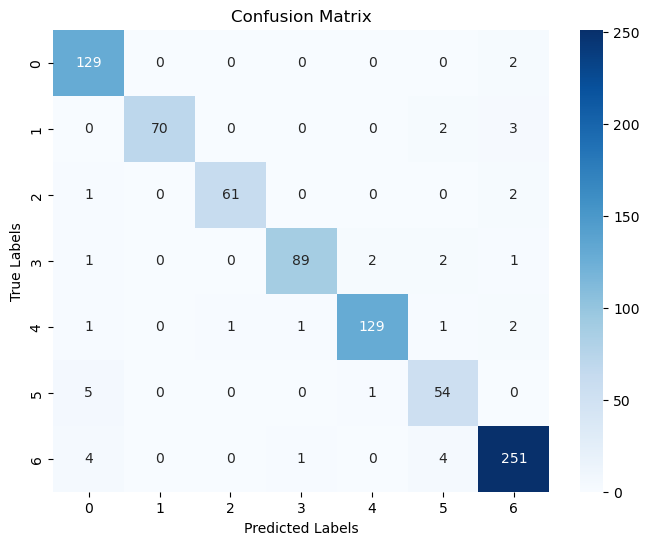

In [ ]:
#initializing confusion matrix
cm = confusion_matrix(y_dog, y_pred_d)
#getting labels for confusion matrix
class_labels = sorted(set(y_dog))
#setting size of confusion matrix image
plt.figure(figsize=(8, 6))
#calling confusion matrix (in form of heatmap)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [ ]:
#TESTING ON CHIMPANZEE DATA
#creating kmers
chimpanzee_data['kmers']=chimpanzee_data.apply(lambda row: create_kmers(row['sequence'], k=k), axis=1)
#flattening
flattened_words_chimpanzee = [' '.join(words) for words in chimpanzee_data['kmers']]
#transforming
X_chimpanzee = vectorizer.transform(flattened_words_chimpanzee)
#labels
y_chimpanzee = chimpanzee_data['class']
#making predictions
y_pred_ch = classifier.predict(X_chimpanzee)
#measuring performance
acc_ch=accuracy_score(y_chimpanzee, y_pred_ch)
prec_ch=precision_score(y_chimpanzee, y_pred_ch, average='weighted')
recall_ch = recall_score(y_chimpanzee, y_pred_ch, average='weighted')
f1_ch = f1_score(y_chimpanzee, y_pred_ch, average='weighted')
#printing results
print('results for chimpanzee data:')
print(f'accuracy: {acc_ch}')
print(f'precision: {prec_ch}')
print(f'recall: {recall_ch}')
print(f'f1 score: {f1_ch}')

results for chimpanzee data:
accuracy: 0.9988109393579072
precision: 0.9988132085576059
recall: 0.9988109393579072
f1 score: 0.9988104719754256


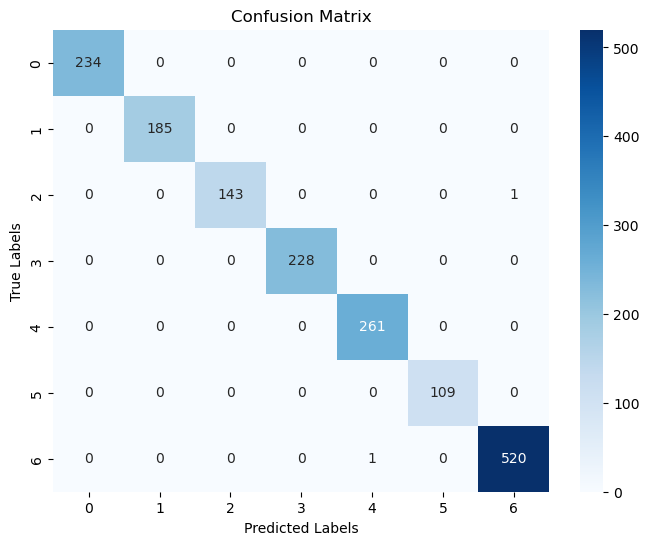

In [ ]:
#initializing confusion matrix
cm = confusion_matrix(y_chimpanzee, y_pred_ch)
#getting labels for confusion matrix
class_labels = sorted(set(y_chimpanzee))
#setting size of confusion matrix image
plt.figure(figsize=(8, 6))
#calling confusion matrix (in form of heatmap)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

ONLY TWO SAMPLES FROM CHIMPANZEE DATA HAVE BEEN MISSCLASSIFIED (MODEL WAS TRAINED PURELY ON HUMAN DATA)

SUMMARY:
<pre>
                    HUMAN                     DOG                 CHIMPANZEE
accuracy:     0.9771689497716894      0.9548780487804878      0.9988109393579072
precision:    0.9774078617610776      0.9562556066634071      0.9988132085576059
recall:       0.9771689497716894      0.9548780487804878      0.9988109393579072
f1 score:     0.9771676697024606      0.9551268020781525      0.9988104719754256